In [1]:
import gc
import time
from datetime import date
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier

## データ読込

In [3]:
df_train = pd.read_csv("train_pseudo.csv")
df_test = pd.read_csv("test.csv")
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
len_train = len(df_train)

## データ探索

In [4]:
profile = pdp.ProfileReport(df_train)
#profile.to_file(outputfile="output_df_train.html")

In [5]:
profile

## データ前処理

In [6]:
# 対数変換
## ヒストグラムでプロットしたときに、分布に偏りがある項目
df_all["log_balance"] = np.log(df_all.balance - df_all.balance.min() + 1)
df_all["log_duration"] = np.log(df_all.duration + 1)
#df_all["log_campaign"] = np.log(df_all.campaign + 1)
df_all["log_pdays"] = np.log(df_all.pdays - df_all.pdays.min() + 1)
df_all = df_all.drop(["balance", "duration", "pdays"], axis=1)

In [7]:
# month を文字列から数値に変換
month_dict = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, 
              "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
df_all["month_int"] = df_all["month"].map(month_dict)

# month と day を datetime に変換
#data_datetime = df_all \
#    .assign(ymd_str=lambda x: "2016" + "-" + x["month_int"].astype(str) + "-" + x["day"].astype(str)) \
#    .assign(datetime=lambda x: pd.to_datetime(x["ymd_str"])) \
#    ["datetime"].values

# datetime を int に変換する
#index = pd.DatetimeIndex(data_datetime)
#df_all["datetime_int"] = np.log(index.astype(np.int64))

# 不要な列を削除
#df_all = df_all.drop(["month", "day", "month_int"], axis=1)
f_all = df_all.drop(["month"], axis=1)
#del data_datetime
#del index

In [8]:
# One Hot Encoding
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
df_dummy = pd.get_dummies(df_all[cat_cols])

In [9]:
# 分析に必要な列を結合
df_tmp = df_all[["age", "month_int", "day", "log_balance", "log_duration", "campaign", "log_pdays", "y"]]
df = pd.concat([df_tmp, df_dummy], axis=1)

## モデリング

lightGBM を試す  
Kaggle の [Home Credit Default Risk](https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code) の kernel を参考にして実装

In [10]:
gc.enable()

In [11]:
# Create Folds
folds = KFold(n_splits=5, shuffle=True, random_state=546789)

In [12]:
data = df[:len_train].drop(["y"], axis=1)
test = df[len_train:].drop(["y"], axis=1)
y = df[:len_train]["y"]

In [13]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

    return oof_preds, sub_preds, feature_importance_df

In [14]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [15]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')

In [16]:
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('recall_precision_curve.png')

In [17]:
oof_preds, test_preds, importances = train_model(data, test, y, folds)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902549	training's binary_logloss: 0.148956	valid_1's auc: 0.869157	valid_1's binary_logloss: 0.164526
[200]	training's auc: 0.92394	training's binary_logloss: 0.135277	valid_1's auc: 0.872748	valid_1's binary_logloss: 0.161783
[300]	training's auc: 0.938946	training's binary_logloss: 0.125839	valid_1's auc: 0.873142	valid_1's binary_logloss: 0.161447
Early stopping, best iteration is:
[294]	training's auc: 0.93798	training's binary_logloss: 0.126442	valid_1's auc: 0.8732	valid_1's binary_logloss: 0.161395
Fold  1 AUC : 0.873200
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899722	training's binary_logloss: 0.15018	valid_1's auc: 0.873772	valid_1's binary_logloss: 0.164287
[200]	training's auc: 0.923149	training's binary_logloss: 0.136197	valid_1's auc: 0.876444	valid_1's binary_logloss: 0.160378
[300]	training's auc: 0.938349	training's binary_logloss: 0.126633	

In [18]:
df_submission = df_test[["id"]].assign(y=test_preds)
df_submission.to_csv("./submission.csv", index=False, header=None, encoding="utf-8")

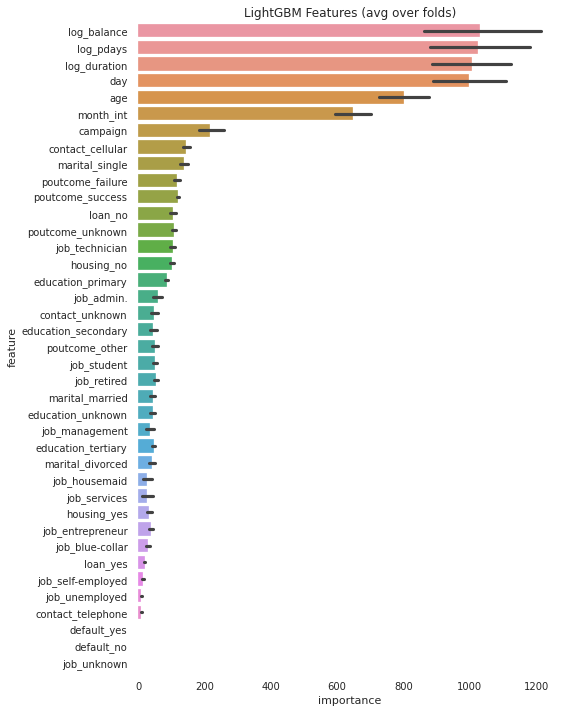

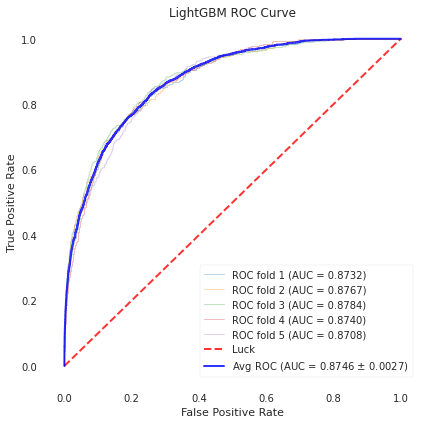

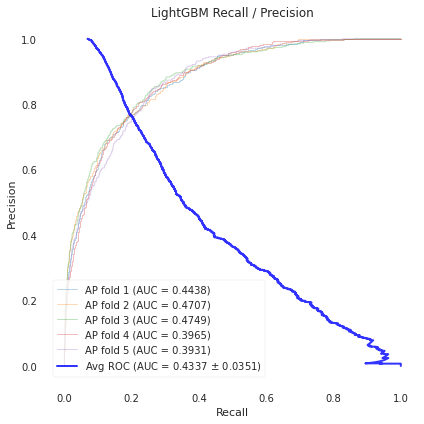

In [19]:
# Display a few graphs
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
display_importances(feature_importance_df_=importances)
display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)